# Итоговый проект (вариант 2)

In [1]:
# загрузим библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # визуализация статистики
from scipy.stats import norm, shapiro, chi2_contingency
from tqdm.auto import tqdm
import pandahouse as ph # подключиться к ClickHouse через pandahouse
import requests # для скачивания опубликованного файла на Я.диске
from urllib.parse import urlencode # для скачивания опубликованного файла на Я.диске

plt.style.use('ggplot')
%matplotlib inline

## Задание 1. A/B–тестирование
### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

#### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента.

In [2]:
# этот блок: в последние дни файлы с яндекс диска не подгружаются (проблема похоже временная, т.к. до этого все работало), код для скачивания не удаляю (закомитил)
# # Файлы сохранили на Яндекс.Диск, получим к ним доступ
# main_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# url_active_studs = 'https://disk.yandex.ru/d/lUtu0P2LNw2Vrw'
# url_checks = 'https://disk.yandex.ru/d/VjwAuY1CFpli1Q'
# url_group_add = 'https://disk.yandex.ru/d/WTLnxwhfConNjw'
# url_groups = 'https://disk.yandex.ru/d/sFzO0EbLiZV6tQ'

# active_studs = pd.read_csv(requests.get(
#     main_url + urlencode(dict(public_key=url_active_studs))).json()['href'])
# checks = pd.read_csv(requests.get(
#     main_url + urlencode(dict(public_key=url_checks))).json()['href'], sep=';')
# group_add = pd.read_csv(requests.get(
#     main_url + urlencode(dict(public_key=url_group_add))).json()['href'], sep=',')
# groups = pd.read_csv(requests.get(
#      main_url + urlencode(dict(public_key=url_groups))).json()['href'], sep=';')

In [3]:
# для реализации пректа сохранил файлы на юпитер.хаб
# получим к ним доступ для загрузки данных
active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-altynbaev/files_for_final_project_v2/Проект_2_active_studs.csv')

checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-altynbaev/files_for_final_project_v2/Проект_2_checks.csv', sep=';')

group_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-altynbaev/files_for_final_project_v2/Проект_2_group_add.csv', sep=',')

groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-altynbaev/files_for_final_project_v2/Проект_2_groups.csv', sep=';')

#### 1.3 Вопросы

#### Предлагаем Вам ответить на следующие вопросы:

* На какие метрики Вы смотрите в ходе анализа и почему?
* Имеются ли различия в показателях и с чем они могут быть связаны?
* Являются ли эти различия статистически значимыми?
* Стоит ли запускать новую механику на всех пользователей?

##### Выполним быстрый анализ файлов

In [4]:
# 1-й файл, пользователи, которые зашли на платформу в дни проведения эксперимента
active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [5]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [6]:
# Подсчёт количества уникальных значений в колонке student_id
len(active_studs['student_id'].unique())

8341

Файл active_studs: id уникальны, пропусков нет, тип данных целочисленный

In [7]:
# 2-й файл с информацией об оплатах пользователей в дни проведения эксперимента
checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [8]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [9]:
# Подсчёт количества уникальных значений в колонке student_id  
len(checks['student_id'].unique())

541

In [10]:
# Подсчёт количества уникальных значений в колонке rev  
len(checks['rev'].unique())

39

Файл checks: тип данных числовой, пропусков нет, id студентов уникальны (541), колонка rev содержит только 39 уникальных значения (вероятно суммы лежат в определенном диапозоне, или имеют ограниченный выбор).  

In [11]:
# 3-й файл с пользователями, который прислали спустя 2 дня после передачи данных
group_add.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [12]:
group_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [13]:
# Подсчёт количества уникальных значений в колонке id  
len(group_add['id'].unique())

92

In [14]:
# Подсчёт количества уникальных значений в колонке grp  
len(group_add['grp'].unique())

2

Файл group_add: уникальных групп - 2 (верно), униикальных id - 92, типы данных верные, пропусков нет

In [15]:
# 4-й файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе 
# (А – контроль, B – целевая группа) 
groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [16]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [17]:
# Подсчёт количества уникальных значений в колонке id  
len(groups['id'].unique())

74484

In [18]:
# Подсчёт количества уникальных значений в колонке grp  
len(groups['grp'].unique())

2

In [19]:
# посмотрим на размеры групп
groups.groupby('grp', as_index=False).count()

,grp,id
0,A,14671
1,B,59813


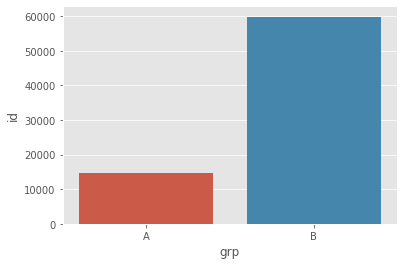

In [20]:
sns.barplot(data=groups.groupby('grp', as_index=False).count(), x="grp", y="id")

Файл groups: уникальных групп - 2 (верно), униикальных id - 74484, типы данных верные, пропусков нет. Тестовая группа значительно больше контрольной.

#### Решение:

Для начала объединим таблицы "groups" (принадлежность пользователей к группам А/В) и "group_add" (дополнительный файл, полученный через 2 дня). 
Переименуем столбцы 'id' в 'student_id', 'grp' в 'group'

In [21]:
groups_all = pd.concat([groups, group_add], ignore_index=True).rename(columns={'id':'student_id', 'grp' : 'group'})
groups_all.head(3)

,student_id,group
0,1489,B
1,1627,A
2,1768,B


проведем небольшой анализ нового фрэйма:

In [22]:
groups_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   student_id  74576 non-null  int64 
 1   group       74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [23]:
groups_all.nunique()

student_id    74576
group             2
dtype: int64

groups_all - типы данных верные, пропусков нет, дубли id отсутствуют. Порядок.

Теперь объединим таблицы 'active_studs', 'checks', используя параметр 'outer' (для максимального сохранения количества исходных данных) :

In [24]:
active_studs_checks = active_studs.merge(checks, how='outer', on='student_id').rename(columns={'rev':'revenue'})
active_studs_checks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8490 entries, 0 to 8489
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  8490 non-null   int64  
 1   revenue     541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 199.0 KB


Значений в "student_id" стало больше - 8490 (файл active_studs - было 8341).. 

т.е. пользователи, платившие в дни эксперимента, не попали в таблицу пользователей, заходивших на платформу в дни экперимента..

Можно предположить, что оплата проводилась за пределами платформы, или это было запланированное списание средств на определенную дату без участия пользователя.. 

Объединим полученные таблицы "groups_all" и "active_studs_checks". 
В итоге должны получить таблицу с данными: пользователи в дни эксперимента, принадлежность к группе (А/В), оплаты в дни эксперимента.

In [25]:
groups_all_merge = groups_all.merge(active_studs_checks, how='outer', on='student_id').fillna(0)
groups_all_merge.head(3)

,student_id,group,revenue
0,1489,B,0.0
1,1627,A,990.0
2,1768,B,0.0


In [26]:
groups_all_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 74575
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  74576 non-null  int64  
 1   group       74576 non-null  object 
 2   revenue     74576 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.3+ MB


Пользователей (студентов) больше не стало. Данные по id  объединены верно.

### Про метрики
Эсперимент запущен для анализа влияния новой механики оплат на сайте. 
Рассмотрим следующие метрики (при анализе оплат):

**ARPU** - средняя выручка на одного пользователя (в какой группе больше платящих пользователей?). Выявляет ценность продукта для пользователей. Мы будем учитывать только активных пользователей (заходивших на сайт в дни эксперимента), т.е. используем **ARPAU** - средняя выручка на одного активного пользователя. Тех, кто оплатил, но на платформе не был - не учитываем.

**ARPPU** - средня выручка на платящего пользователя (средний чек). Как восприняли покупатели изменение цен? 

**CR** - конвертация пользователя в покупателя. Этот коэффициент поможет оценить - были ли предпринятые действия (изменение механики оплат) эффективными

In [27]:
# количество всех пользователей по группам
groups_all_merge.groupby('group').student_id.count()

group
A    14693
B    59883
Name: student_id, dtype: int64

In [28]:
# # не пригодилось, но удалять не стал:
# # создадим колонку 'did_visit' и присвоим активным пользователям "1", пригодится для отбора активных пользоватей 
# active_studs['did_visit'] = 1
# active_studs.head(2)

In [29]:
# создадим колонку 'did_pay' и присвоим платившим пользователям "1" (в дни захода на сайт), пригодится для анализа воронки продаж 
checks['did_pay'] = 1
checks_true = checks.drop(columns=['rev'])
checks_true.head(2)

,student_id,did_pay
0,1627,1
1,3185,1


In [30]:
# объединим фрэймы активных пользователей (визитеров), + данные по оплатам, с ранее сгенерированной таблицей "groups_all_merge"
# получим данные для анализа по активным пользователям (заходившим на сайт в дни эксперимента)
visits_payments = active_studs \
    .merge(groups_all_merge, how='left', on='student_id') \
    .merge(checks_true, how='left', on='student_id').fillna(0)
visits_payments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  8341 non-null   int64  
 1   group       8341 non-null   object 
 2   revenue     8341 non-null   float64
 3   did_pay     8341 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 325.8+ KB


In [31]:
visits_payments.tail(3)

,student_id,group,revenue,did_pay
8338,3598448,B,0.0,0.0
8339,3610547,B,290.0,1.0
8340,205705,B,0.0,0.0


#### ARPAU

In [32]:
# Посчитаем ARPAU (средняя выручка на одного активного пользователя) по группам
arpau = visits_payments.groupby('group', as_index=False)\
                .agg({'revenue': 'mean'})\
                .rename(columns={'revenue': 'ARPAU'})
arpau

,group,ARPAU
0,A,47.347204
1,B,58.058798


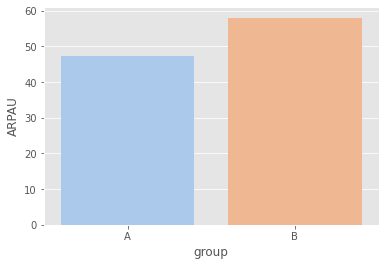

In [33]:
sns.barplot(data=arpau, x="group", y="ARPAU", palette="pastel")

ARPAU в тестовой группе выше (средняя сумма чека на одного визитера больше).

#### ARPPU

In [34]:
# Посчитаем ARPPAU (средняя выручка на платящего пользователя) по группам
arppu = visits_payments.query('did_pay == 1') \
             .groupby('group', as_index=False) \
             .agg({'revenue':'mean'}) \
             .rename(columns={'revenue':'ARPPU'})
arppu

,group,ARPPU
0,A,933.589744
1,B,1257.878992


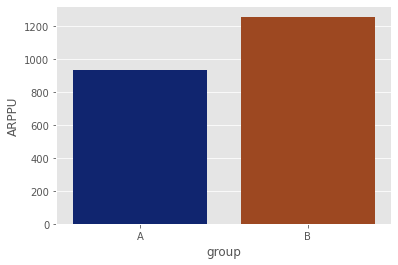

In [35]:
sns.barplot(data=arppu, x="group", y="ARPPU", palette="dark")

ARPPU в тестовой группе выше (средний чек больше)

#### CR

In [36]:
# посчитаем конверсию в покупку по группам
cr_for_visits_payments = visits_payments.groupby('group', as_index=False) \
            .agg({'student_id': 'count', 'did_pay': 'sum'}) \
            .rename(columns={'student_id':'count_id'})
cr_for_visits_payments

,group,count_id,did_pay
0,A,1538,78.0
1,B,6803,314.0


In [37]:
cr_for_visits_payments['CR'] = cr_for_visits_payments.did_pay / cr_for_visits_payments.count_id*100
# cr_for_visits_payments[['group', 'CR']]
cr_for_visits_payments

,group,count_id,did_pay,CR
0,A,1538,78.0,5.071521
1,B,6803,314.0,4.615611


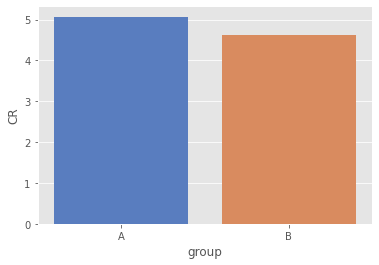

In [38]:
sns.barplot(data=cr_for_visits_payments, x="group", y="CR", palette="muted")

CR в тестовой группе оказался ниже. При новом механизме оплат частота покупок уменьшилась.


***О различии в показателях***

В дни эксперимента у тестовой группы сумма чека больше (это плюс), но конверсия в покупателя стала ниже (это минус). Результат эксперимента противоречивый. Предположу, что в тестовой группе посетители формируют более дорогие заказы, чем в контрольной. При этом посетители контрольной группы выбирают опции дешевле, соответственно совершают покупки свободнее (чаще). Далее (ниже) будем проверять верность наших предположений, используя статистические методы анализа данных.

### Статистика

Первичный подход - визуальный - диаграмма размаха. 

Применим к сумме чека (фильтруем только пользователей, сделавших покупки)

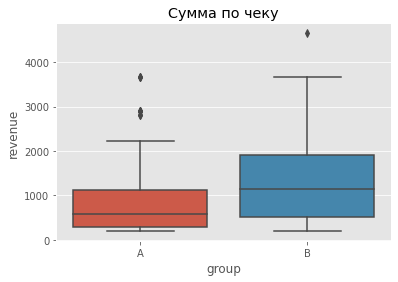

In [39]:
sns.boxplot(data=visits_payments.query('revenue > 0'), x='group', y='revenue');
plt.title("Сумма по чеку");

Беглый взгляд говорит, что изменение механики оплаты позитивно сказалось на сумме чека в тестовой группе (почти х2 увеличение)

Визуализируем распределение данных по оплатам на нормальность:

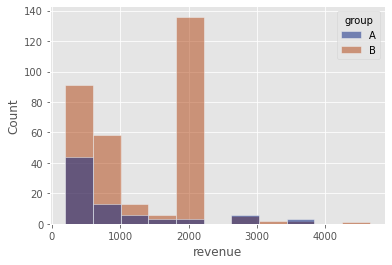

In [40]:
sns.histplot(x='revenue', hue='group', data=visits_payments.query('revenue > 0'), palette='dark')
plt.show()

Распределение НЕнормальное в обеих группах, левый скос. В тестовой группе ярко выраженный количественный рост среднего чека в зоне 2000 рублей (была ли это маркетинговая компания (акция), лучше уточнить у команды).

In [41]:
# посмотрим на числовой ряд тестовой группы "В", и попробуем увидеть данные в зоне "бурного роста" покупок
visits_payments.query('group == "B" ').groupby('revenue').count()

,student_id,group,did_pay
revenue,,,
0.0000,6489,6489,6489
199.0000,27,27,27
290.0000,45,45,45
398.0000,6,6,6
489.0000,1,1,1
580.0000,5,5,5
590.0000,6,6,6
597.0000,1,1,1
690.0000,13,13,13


В приведенной таблице мы видим массовое количество чеков в зоне 1900 рублей, и не совсем понятной суммы 1900.0001 руб. (возможно привязана к акции).

In [42]:
# посмотрим на числовой ряд группы "A", и попробуем увидеть данные в зоне 1900 рублей
visits_payments.query('group == "A" ').groupby('revenue').count()

,student_id,group,did_pay
revenue,,,
0.0,1460,1460,1460
199.0,5,5,5
290.0,25,25,25
398.0,1,1,1
489.0,2,2,2
580.0,6,6,6
590.0,5,5,5
690.0,4,4,4
840.0,3,3,3


В приведенной таблице по группе "А" мы вообще не видим (!) чеков в зоне 1900 рублей ( 1900.0001 руб.). **Это предмет обсуждения с командой.**

При ненормальном распределении Т-test использовать нельзя. Обратимся к U-критерий Манна-Уитни, он не зависит от выбросов и концентрируется на центре распределения. 
Но тест Манна-Уитни плохо работает, когда в данных много одинаковых значений (повторов, tied ranks), проверим повторяемость значений:

In [43]:
#  количество уникальных значений (с выручкой больше нуля)
visits_payments.query('revenue > 0').nunique()

student_id    392
group           2
revenue        38
did_pay         1
dtype: int64

90% - повторяющиеся значения "revenue". Тест Манна-Уитни использовать нельзя. 

Воспользуемся ***Бутстрап*** - позволяет роверять гипотезы с помощью повторных выборок при любых параметрах распределения.

В полученных подвыборках считаются статистики (среднее, медиана и т.п.), в нашем случае - среднее.

Из статистик можно получить ее распределение и взять доверительный интервал.

In [44]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_2), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

#### Анализ ARPAU

Сразу отметим, что отношение количества покупок к активным пользователям (визитерам) - очень мало: 392 / 8341, менее 5% в каждой группе. Другими словами - более 95% активных пользователей не совершали покупки, что ставит под сомнение в нашем случае полезность показателя ARPAU, в расчете которого акттвные пользователи учтены. В любом случае проведем тест на стат.значимость.

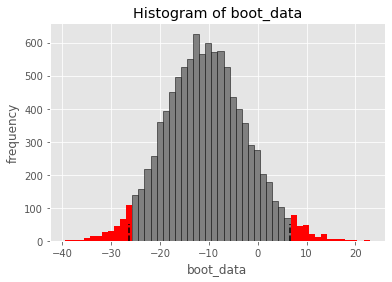

In [45]:
bootstrap_arpau = get_bootstrap(visits_payments.query('group == "A" ').revenue, visits_payments.query('group == "B" ').revenue)

In [46]:
bootstrap_arpau['p_value'] 

0.19866455253725257

***Интерпретация результата:*** 0 попал в доверительный интервал, значит альтернативная гипотеза на заданном уровне значимости не принимается, по ARPAU статистической ***разницы нет***.

#### Анализ ARPPU


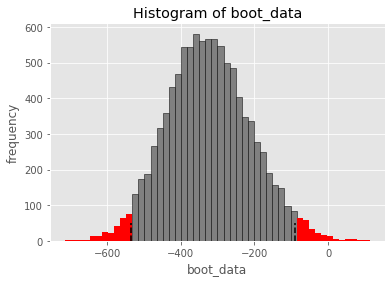

In [47]:
bootstrap_arppu = get_bootstrap(visits_payments.query('group == "A" and revenue > 0').revenue, visits_payments.query('group == "B" and revenue > 0').revenue)

In [48]:
bootstrap_arppu['p_value'] 

0.004420350719082125

***Интерпретация результата:*** 0 не попал в доверительный интервал, значит отклоняем нулевую гипотезу и принимаем альтернативную - по ARPPU статистически значимая ***разница есть***.

**Анализ CR**

Конверсия в покупателя относится к категориальныем данным, используем тест **хи-квадрат**, который поможет определить - есть ли зависимость частоты оплат от принадлежности к группе. Проверим гипотезы:

- H0: зависимость отсутствует

- H1: зависимость есть

In [49]:
visits_payments.head(3)

,student_id,group,revenue,did_pay
0,581585,A,0.0,0.0
1,5723133,A,0.0,0.0
2,3276743,B,0.0,0.0


Для применения Хи-квадрат теста нужно подготовить данные. Воспользуемся функцией *crosstab* - создает таблицу кросс-табуляции, которая может показать частоту, с которой появляются определенные группы данных (0 - не платили, 1 - платили)

In [50]:
visits_payment_cross = pd.crosstab(visits_payments['group'], visits_payments['did_pay'])
visits_payment_cross

did_pay,0.0,1.0
group,,
A,1460,78
B,6489,314


In [51]:
# запустим метод Хи-квадрат
chi2, prob, df, expected = chi2_contingency(visits_payment_cross)
# Выведем p-value
print("p-value: {}".format(prob))

p-value: 0.48625240457231045


***Интерпретация результата:*** p-value оказался многим больше 0,05. Это дает нам основание отклонить альтернативную гипотезу Н1. Оставляем нулевую гипотезу - ***зависимость отсутсвует***.

## Выводы по заданию

In [52]:
# напомним (выведем) полученные метрики:
arpau.merge(arppu, on='group', how='right')\
.merge(cr_for_visits_payments, on='group', how='right')\
.drop(['count_id', 'did_pay'], axis=1)

,group,ARPAU,ARPPU,CR
0,A,47.347204,933.589744,5.071521
1,B,58.058798,1257.878992,4.615611


Показатель ARPAU - в тестовой группе средний чек по группе больше. Но мы не можем уверенно полагаться на этот расчет, в нем много шума (более 95% пользователей не совершало покупок). Тест не обнаружил различий.

Показатель ARPPU - в тестовой группе средний чек покупателя больше. Тест подтвердил различия. Но нужно получить дополнительную информацию у команды о причинах всплеска в тестовой группе покупок в зоне 1900 и 1900,0001 рублей (почему эти суммы так повлияли на поведение пользователей?).

Метрика CR в тестовой группе оказалась ниже. Но проведя статистический тест мы обнаружили, что зависимость отсутствет (оставили нулевую гипотезу).  

Стоит ли запускать новую механику на всех пользователей?

Если вопрос о всплеске покупок в зоне 1900 ( 1900,0001) рублей, после обсуждения с командой, окажется "ложной тревогой", то ответ положительный:

ARPPU растет. CR не ухудшается (связь не выявлена).

## Задание 2. SQL
#### 2.1 Очень усердные ученики.

##### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

##### 2.1.2 Задача

Дана таблица default.peas

Необходимо написать оптимальный запрос, который даст *информацию о количестве очень усердных студентов*.

NB! Под очень усердным студентом мы понимаем студента, который правильно решил 20 задач за *текущий месяц*.

In [53]:
# подключимся к ClickHouse (БД default)
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [54]:
# создаем запрос
q_1 = '''
SELECT 
    COUNT (*) AS st_count
FROM
    (
    SELECT 
        st_id, 
        SUM(correct) AS sum_correct
    FROM 
        default.peas
    WHERE 
        timest = date_trunc('month', now( ))
    GROUP BY 
        st_id
    HAVING 
        sum_correct >= 20
        )
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
query_1 = ph.read_clickhouse(query=q_1, connection=connection_default)
query_1

,st_count
0,0


**Ответ:**

В текущем месяце нет усердных учеников.

In [55]:
# дополнительно убедимся - когда были усердные ученики, была ли такая ситуация: 
q_2 = '''
SELECT
    month,
    COUNT(st_id) as st_count
FROM 
    (
    SELECT 
        st_id,
        toStartOfMonth(timest) as month
    FROM 
        default.peas
    WHERE
        correct == 1 
    GROUP BY
        st_id,
        month
    HAVING 
        COUNT(correct) >= 20
    )
GROUP BY  
    month
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
query_2 = ph.read_clickhouse(query=q_2, connection=connection_default)
query_2

,month,st_count
0,2021-10-01,136


Видим, что в Октябре 2021 усердные ученики все же были.

#### 2.2 Оптимизация воронки

##### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

##### 2.2.2 Задача

Дана таблица default.peas

Дана таблицы: default.peas (см. выше), default.studs и default.final_project_check
    
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
- ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

Все данные находятся в табличном виде в Clickhouse

In [56]:
q_3 = '''
WITH a as 
    (
    SELECT 
    students.st_id AS student_id, -- id студента
    students.test_grp AS test_group, -- принадлежность студента к группе тестирования
    rev_st.revenue_st AS revenue_student, -- выручка
    activity.activity_st AS active_student, -- активные студенты (больше 10 задач правильно)
    math_data.activity_math AS active_math, -- активные математики (равно или больше 2 задач по математике правильно)
    math_data.revenue_math AS revenue_math -- выручка математиков
        
    FROM default.studs AS students     
        
        LEFT JOIN  -- джойним students с данными по выручке 
        (
            SELECT
                st_id,
                sum(money) as revenue_st  -- выручка по студенту
            FROM default.final_project_check
            GROUP BY st_id
        ) as rev_st      
        ON students.st_id = rev_st.st_id        
        
        LEFT JOIN  -- джойним students с данными по активности
        (
            SELECT 
                st_id,
                IF(sum(correct) > 10, 1, 0) AS activity_st -- присвоим булевы значения активным студентам
            FROM default.peas 
            GROUP BY st_id
        ) as activity  
        ON students.st_id = activity.st_id
            
        LEFT JOIN  -- джойним students с данными по активным математикам
        (
            SELECT
                st_id,
                revenue_math,
                activity_math
            FROM  
                (
                SELECT 
                    st_id,
                    IF(sum(correct) >= 2, 1, 0) AS activity_math -- присвоим булевы значения активным математикам
                FROM default.peas
                WHERE subject == 'Math'
                GROUP BY st_id
                ) as act_math  
            
                LEFT JOIN
                (
                SELECT 
                    st_id,
                    sum(money) as revenue_math -- выручка по математикам
                FROM default.final_project_check
                WHERE subject = 'Math'
                GROUP BY st_id
                ) as rev_math           
                ON rev_math.st_id = act_math.st_id
        ) as math_data
        ON students.st_id = math_data.st_id        
    )
    

SELECT
-- ARPU = выручка / кол-во студентов
-- ARPAU = выручка активных студентов / кол-во активных студентов
-- CR = кол-во студентов-покупателей / общее кол-во студентов
-- CR активных студентов = кол-во покупателей из активных студентов / общее кол-во активных студентов
-- CR математиков = кол-во покупателей из активных математиков / общее кол-во активных математиков
    test_group,
    ROUND(sum(revenue_student) / count(student_id), 2) AS ARPU, 
    ROUND(sum(if(active_student == 1, revenue_student, null )) / count(distinct if(active_student = 1, student_id, null)), 2) AS ARPAU, 
    ROUND((countIf(revenue_student, revenue_student > 0) / count(student_id) * 100), 2) AS CR,
    ROUND((countIf(revenue_student, revenue_student > 0 and active_student == 1) / countIf(student_id, active_student == 1) * 100), 2) AS CR_active, 
    ROUND((countIf(revenue_math, revenue_math > 0 and active_math == 1) / countIf(student_id, active_math == 1) * 100), 2) AS CR_math 
FROM a     
GROUP BY test_group
'''

**Ответ:**

In [57]:
# отправляем запрос и записываем результат в пандасовский датафрейм
query_3 = ph.read_clickhouse(query=q_3, connection=connection_default)
query_3

,test_group,ARPU,ARPAU,CR,CR_active,CR_math
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


## Задание 3. Python
### 3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [58]:
# этот блок: в последние дни файлы с яндекс диска не подгружаются (проблема похоже временная, т.к. до этого все работало), код для скачивания не удаляю (закомитил)
# # повторно обратимся к файлам на Яндекс.Диске
# cloud_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# url_active_studs = 'https://disk.yandex.ru/d/Wz6oci7RLmc6Bg'
# url_checks = 'https://disk.yandex.ru/d/xD4L_d-WCkxYOg'
# url_group_add = 'https://disk.yandex.ru/d/VM72bwL1Yvdx_g'
# url_groups = 'https://disk.yandex.ru/d/vRna72CKCzCwmg'

# active_studs = pd.read_csv(requests.get(
#                 cloud_url + urlencode(dict(public_key=url_active_studs))).json()['href'], sep=';')
# checks = pd.read_csv(requests.get(
#                 cloud_url + urlencode(dict(public_key=url_checks))).json()['href'], sep=';')
# group_add = pd.read_csv(requests.get(
#                 cloud_url + urlencode(dict(public_key=url_group_add))).json()['href'], sep=',')
# groups = pd.read_csv(requests.get(
#                 cloud_url + urlencode(dict(public_key=url_groups))).json()['href'], sep=';')

In [59]:
# Создадим функцию для получения метрик
# url - новый файл group_add
def metrics_add(url):
    '''Автоматически принимает информацию из дополнительного файла groups_add.csv. '''
    
    # путь к скачиваемым файлам
    active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-altynbaev/files_for_final_project_v2/Проект_2_active_studs.csv')
    checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-altynbaev/files_for_final_project_v2/Проект_2_checks.csv', sep=';')
    group_add = pd.read_csv(f'/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-altynbaev/files_for_final_project_v2/{url}', sep=',')
    groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-altynbaev/files_for_final_project_v2/Проект_2_groups.csv', sep=';')

    # в этом блоке использую код из первого задания для получения метрик 
    groups_all = pd.concat([groups, group_add], ignore_index=True).rename(columns={'id':'student_id', 'grp' : 'group'})
    active_studs_checks = active_studs.merge(checks, how='outer', on='student_id').rename(columns={'rev':'revenue'})
    groups_all_merge = groups_all.merge(active_studs_checks, how='outer', on='student_id').fillna(0)
    checks['did_pay'] = 1
    checks_true = checks.drop(columns=['rev'])
    visits_payments = active_studs \
            .merge(groups_all_merge, how='left', on='student_id') \
            .merge(checks_true, how='left', on='student_id').fillna(0)
    # получим ARPAU
    arpau = visits_payments.groupby('group', as_index=False)\
             .agg({'revenue': 'mean'})\
             .rename(columns={'revenue': 'ARPAU'})
    # получим ARPPU
    arppu = visits_payments.query('did_pay == 1') \
             .groupby('group', as_index=False) \
             .agg({'revenue':'mean'}) \
             .rename(columns={'revenue':'ARPPU'})
    # получим CR
    cr_for_visits_payments = visits_payments.groupby('group', as_index=False) \
            .agg({'student_id': 'count', 'did_pay': 'sum'}) \
            .rename(columns={'student_id':'count_id'})
    cr_for_visits_payments['CR'] = cr_for_visits_payments.did_pay / cr_for_visits_payments.count_id*100
    # объединим ARPAU, ARPPU, CR
    arpau_arppu_cr = arpau.merge(arppu, on='group', how='right')\
            .merge(cr_for_visits_payments, on='group', how='right')\
            .drop(['count_id', 'did_pay'], axis=1)

    return arpau_arppu_cr


In [60]:
# Передадим в функцию новый файл
renew_metric = metrics_add('Проект_2_group_add.csv')
renew_metric

,group,ARPAU,ARPPU,CR
0,A,47.347204,933.589744,5.071521
1,B,58.058798,1257.878992,4.615611


In [61]:
# создадим фунуцию для визуализации обновленной метрики
def new_chart(renew_metric):
    ''' Выводит графики по пересчитанным метрикам.'''
    
    fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
    ARPAU = sns.barplot(ax=axes[0], data=renew_metric, x="group", y="ARPAU", palette="pastel")
    ARPPU = sns.barplot(ax=axes[1], data=renew_metric, x="group", y="ARPPU", palette="dark")
    CR = sns.barplot(ax=axes[2], data=renew_metric, x="group", y="CR", palette="muted")
    
    # переименуем оси и графики для удобства          
    ARPAU.set(xlabel='',
             ylabel='',
             title='ARPAU')
        
    ARPPU.set(xlabel='',
              ylabel='',
              title='ARPPU')
    
    CR.set(xlabel='',
           ylabel='',
           title='CR')

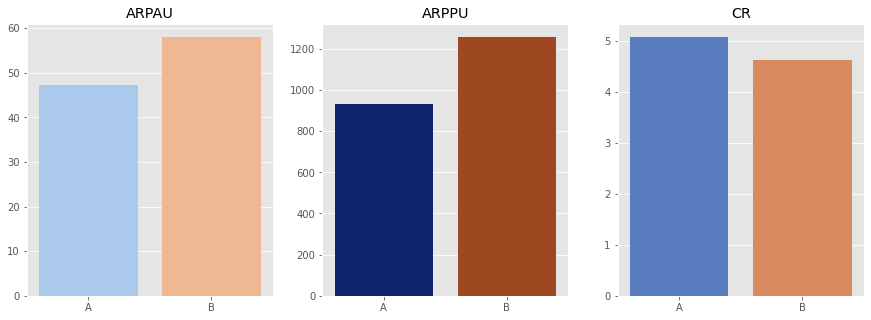

In [62]:
# Передадим в функцию обновленный файл метрики
new_chart(renew_metric)

Задание выполнено.